In [0]:
!pip install librosa

In [0]:
fs=16000
duration = 5  # seconds

In [0]:
#import pyaudio
import wave
import matplotlib.pyplot as plt
%matplotlib inline
#import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import librosa


In [0]:
myrecording = sd.rec(duration * fs, samplerate=fs, channels=1,dtype='float64')
print ("Recording Audio")
sd.wait()
print( "Audio recording complete , Play Audio")

Recording Audio
Audio recording complete , Play Audio


In [0]:
sd.play(myrecording, fs)
sd.wait()
print( "Play Audio Complete")

Play Audio Complete


In [0]:
myrecording,sr = librosa.load('happy_5.wav',16000)

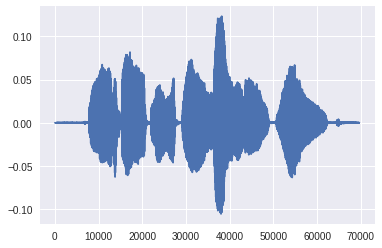

In [0]:
plt.plot(myrecording)

In [0]:
myrecording = myrecording.reshape(myrecording.shape[0],)
mfcc = librosa.feature.mfcc(myrecording,sr = 16000)


In [0]:
mfcc.shape

(20, 137)

In [0]:
def pad(mfcc):
    mfcc_new = []
    arr = []
    for j in range(20):
      val1 = np.array(mfcc[j]).shape[0]
      val = np.pad(mfcc[j], (0, 200-val1), 'constant')
      arr.append(val)
    mfcc_new.append(np.array(arr))
    return np.array(mfcc_new)

In [0]:
mfcc = pad(mfcc)
mfcc.shape

(1, 20, 200)

In [0]:
def get_log_energy(sample_data):

    hann_win = np.hanning(len(sample_data))
    energy = np.log10(np.sum(np.square(sample_data * hann_win)))

    return energy
def freq_from_fft(sig, fs):
    w = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(w))
    idx = np.argmax(np.abs(w))
    freq = freqs[idx]
    freq_in_hertz = abs(freq * fs)
    return (freq_in_hertz)

In [0]:
energy = get_log_energy(myrecording)
pitch  = freq_from_fft(myrecording,16000)
pitch

272.05882352941177

In [0]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
def append_values(data,value):
    new_data = []
    for i in range(data.shape[0]):
        line = np.full((1,data[i].shape[1]),value)[0]
        line = line.reshape(1,data[i].shape[1])
        data1 = np.concatenate((data[i],line))
        new_data.append(data1)
    return np.array(new_data)

In [0]:
mfcc

array([[[-6.87669992e+02, -6.83930059e+02, -6.82163980e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.16737231e+00,  1.42904623e+01,  1.57462707e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.92821846e+00,  1.25344696e+01,  1.29831095e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.37212394e+00, -2.43329917e+00, -3.69448687e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.20670183e+00, -1.18032899e+00, -2.22756741e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.22830480e-01,  3.54739861e-01,  1.71607012e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

In [0]:
mfcc = mfcc-np.mean(mfcc)/np.std(mfcc)
mfcc

array([[[-6.87458812e+02, -6.83718879e+02, -6.81952800e+02, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01],
        [ 9.37855231e+00,  1.45016423e+01,  1.59574507e+01, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01],
        [ 8.13939846e+00,  1.27456496e+01,  1.31942895e+01, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01],
        ...,
        [-2.16094394e+00, -2.22211917e+00, -3.48330688e+00, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01],
        [-9.95521835e-01, -9.69148994e-01, -2.01638742e+00, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01],
        [ 6.34010474e-01,  5.65919855e-01,  3.82787006e-01, ...,
          2.11179994e-01,  2.11179994e-01,  2.11179994e-01]]])

In [0]:
pitch = pitch/1000
energy = energy/10

In [0]:
mfcc_new = append_values(mfcc,pitch)
mfcc_new = append_values(mfcc_new,energy)

In [0]:
specs = np.asarray(mfcc_new).reshape(len(mfcc_new),mfcc_new.shape[1],mfcc_new.shape[2],1)
#specs = np.asarray(features_songs).reshape(len(features_songs),21,200,1)
features = np.concatenate((specs, np.zeros(np.shape(specs))), axis = 3)
for i in range(len(features)):
    features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])

In [0]:
features.shape

(1, 22, 200, 2)

In [0]:
x_test = features

In [0]:
preds = loaded_model.predict(x_test, verbose=0)

In [0]:
emotion_id = np.argmax(preds)

In [0]:
emotions = {
        0:"Neutral", 
        1:"Calm" , 
        2:"Happy", 
        3:"Sad" , 
        4:"Angry" ,
        5:"Fearful",
        6:"Disgust",
        7:"Surprised"
    }

In [0]:
print("Are you",emotions[emotion_id],"?")

Are you Sad ?


In [0]:
preds

array([[0.000000e+00, 0.000000e+00, 3.796418e-13, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]],
      dtype=float32)